In [1]:
from langchain_gigachat.chat_models import GigaChat
import yaml

def ask_question(question:str) -> int:
    """Переспросить неоднозначные моменты.
        Если видишь несостыковку данных таблицы и вопроса, спроси у пользователя.
        Спрашивай пока не получишь ответы на все вопросы.
    """
    return input(question)

tools = [ask_question]

with open("gpt_db/data/confs/config.yaml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
GIGACHAT_CREDENTIALS = config["GIGACHAT_CREDENTIALS"]

llm = GigaChat(
            credentials=GIGACHAT_CREDENTIALS,
            model="GigaChat-2-Max",
            verify_ssl_certs=False,
            temperature=0.01  # можно настраивать
        )
llm_with_tools = llm.bind_tools(tools)

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
import datetime

def _load_instruction():
   with open('gpt_db/data/confs/instruction_sql.txt', 'r', encoding='utf-8') as file:
      instruct = file.read().strip()
   with open('gpt_db/data/confs/otgruzki_structure.txt', 'r', encoding='utf-8') as file:
      db_shema = file.read().strip()
   with open('gpt_db/data/confs/divisions.txt', 'r', encoding='utf-8') as file:
      divisions = file.read().strip()
   return instruct.replace("[otgruzki_structure]", db_shema).\
      replace("[divizions]", divisions).replace("[date]", str(datetime.datetime.now())[:10])

def _load_otgr_div():
   with open('gpt_db/data/confs/otgruzki_structure.txt', 'r', encoding='utf-8') as file:
      db_shema = file.read().strip()
   with open('gpt_db/data/confs/divisions.txt', 'r', encoding='utf-8') as file:
      divisions = file.read().strip()
   return db_shema, divisions

otgruzki_structure, divisions = _load_otgr_div()

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

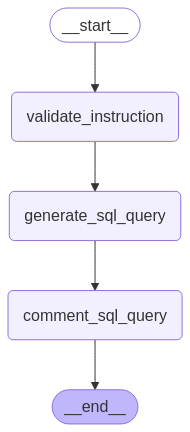

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import List
from langgraph.checkpoint.memory import MemorySaver
import json
memory = MemorySaver()

from dataclasses import dataclass
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Ваша обёртка над моделью, pseudo:
# from my_llm_wrapper import llm

@dataclass
class MessagesState:
    messages: List[AIMessage]

def append_to_json_file(filename, record: dict):
    """
    Записывает строку JSON в указанный файл, добавляя (append) в конец.
    """
    with open(filename, 'a', encoding='utf-8') as f:
        json.dump(record, f, ensure_ascii=False)
        f.write('\n')  # перевод строки для хранения отдельных записей

def load_history_from_json(filename: str) -> list:
    """
    Считывает все строки из `filename`, парсит JSON 
    и формирует список сообщений HumanMessage/AIMessage 
    (в порядке, в котором они записаны в файле).
    """
    messages = []
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                record = json.loads(line)
                msg_type = record.get("type")
                content = record.get("content", "")
                
                if msg_type == "validate_instruction":
                    # Считаем это пользовательским сообщением
                    messages.append(HumanMessage(content=content))
                elif msg_type == "agent_answer":
                    # Считаем это ответом модели
                    messages.append(AIMessage(content=content))
                else:
                    # Если в файле есть другие типы — можно либо игнорировать,
                    # либо обрабатывать как SystemMessage, если нужно.
                    pass
    except FileNotFoundError:
        # Файл может не существовать при первом запуске
        pass
    
    return messages

#
# Узел 1: Проверка вопроса, при необходимости переспрашивает, 
# пока не получит "ok" – значит, всё скорректировано.
#
def validate_instruction(state: MessagesState) -> MessagesState:
    """
    На этом шаге:
    1) Модель проверяет, нет ли несостыковок между запросом пользователя и данными.
    2) Если всё ок, в ответе возвращает "ok".
    3) Когда ответ "ok", мы ещё раз просим кратко сформулировать "конкретную инструкцию"
    4) Этот результат используем как вход для следующей ноды, чтобы генератор SQL точно знал,
       какие поля выводить и как.
    """
    user_instruction = state.messages[0].content.strip()

    history_messages = load_history_from_json("gpt_db/data/dialogs_cash/history.json")[-6:]

    sys_msg = SystemMessage(content=(
        f"Вот описание структуры:\n{otgruzki_structure}\n\n"
        f"Дивизионы:\n{divisions}\n"
        f"Сегодняшняя дата: {datetime.date.today().strftime('%Y%m%d')}\n\n"
        "Ты ассистент, проверяющий,"
        "1) Нет ли несостыковок между запросом пользователя и доступными полями. "
        "2) Должно быть точно понятно какие поля выводить, если это не так то спрашивай.\n"
        "3) Запрещено выводить все поля, спрашивай какие поля выводить если непонятно\n"
        "Если что-то не ясно, попроси уточнить (коротко). "
        "Если всё ок, ответь 'ok'. "
        "НЕ говори, что нет поля даты, оно точно есть."
        "Отвечай строго одним предложением для уточнений или 'ok'. Без воды."
    ))

    human_msg = HumanMessage(content=f"Пользовательский запрос: {user_instruction}")
    conversation = [sys_msg] + history_messages + [human_msg]
    # conversation = [sys_msg] + [human_msg]
    # conversation = [sys_msg, human_msg]

    while True:
        response = llm.invoke(conversation)
        conversation.append(response)
        result_text = response.content.strip()

        # Проверяем, ответил ли ассистент "ok"
        lower_text = result_text.lower()
        if lower_text.startswith("ok") or lower_text.startswith("ок"):
            # Модель сообщила, что всё в порядке.
            # Теперь просим её дать финальную инструкцию.
            finalize_msg = SystemMessage(content=(
                "Сожми разговор с пользователем до одной инструкции, ничего своего не добавляй и не спрашивай.\n"
            ))
            
            # Берём всё из conversation, кроме первой системной инструкции, 
            # и вставляем ОДНО новое системное сообщение (finalize_msg)
            finalize_conversation = conversation[1:]  
            finalize_conversation.insert(0, finalize_msg)
            
            # Добавляем текущее сообщение пользователя
            finalize_conversation.append(HumanMessage(content=user_instruction))
            
            finalize_resp = llm.invoke(finalize_conversation)
            print("✅ Инструкция принята:", finalize_resp.content)


            # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
            record = {
                "type": "validate_instruction",
                "content": finalize_resp.content
            }
            append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
            # ==================================

            # Возвращаем это финальное сообщение в State
            return MessagesState(messages=[AIMessage(content=finalize_resp.content.strip())])
        else:
            # Модель просит уточнений
            print("⚠️ Уточнение от модели:", result_text)
            clarification = input("🔄 Введите уточнённую инструкцию: "+result_text)
            if not clarification.strip():
                raise KeyError("Пользователь не дал уточнение, прерывание.")

            # Добавляем уточнение пользователя
            conversation.append(HumanMessage(content=clarification))
            user_instruction += f"\nОтвет от модели: {result_text}\nОтвет человека: {clarification}\n"


#
# Узел 2: Генерация SQL по строгому формату
#
def generate_sql_query(state: MessagesState) -> MessagesState:
    """
    Берём итоговую формулировку (после валидации) из state.messages[-1].content
    и просим модель сгенерировать SQL по жёстким правилам
    (GROUP BY для характеристик, SUM/COUNT для показателей, нет SELECT *, etc.).
    """
    user_query = state.messages[-1].content.strip()
    
    sys_msg = SystemMessage(content=(
        "Ты – эксперт по SQL (HANA) и анализу данных. Все запросы идут ТОЛЬКО к таблице:\n"
        "SAPABAP1.ZZSDM_117_CUS\n"
        "Схема таблицы"
        "[otgruzki_structure]\n"
        "Дополнительные данные:\n"
        "[divizions] (коды и названия дивизионов)\n"
        "Сегодняшняя дата - [date]"
        "Строгие правила:\n"
        " - Один показатель (если явно не прописано другого)\n"
        " - Только существующие поля (из otgruzki_structure)\n"
        " - Группировка (GROUP BY) по 'характеристикам'\n"
        " - Агрегация (SUM/COUNT) для 'показателей'\n"
        " - Явная дата в WHERE: формат 'YYYYMMDD'\n"
        " - Не показывать данные за все время\n"
        " - По умолчанию цены в рублях\n"
        " - Проверка деления на 0: CASE WHEN ...\n"
        " - LIMIT 1, если не указано иное\n"
        " - Отгрузки считаем по коду фактуры\n"
        " - Запрещено: WITH, NULLIF, SELECT *, ...\n"
        " - Наценка = (маржа / себестоимость) * 100\n\n"
        "Ответ дай ТОЛЬКО в виде SQL-запроса, без всяких пояснений и приписок."
    ).replace("[otgruzki_structure]", otgruzki_structure).replace("[divizions]", divisions).replace("[date]", str(datetime.datetime.now())[:10]))
    human_msg = HumanMessage(content=user_query)
    conversation = [sys_msg, human_msg]

    response = llm.invoke(conversation)
    sql_query = response.content.strip()

    return MessagesState(messages=[AIMessage(content=sql_query)])


#
# Узел 3: Генерация комментария и сборка финального результата
#
def comment_sql_query(state: MessagesState) -> MessagesState:
    """
    Берём SQL из предыдущего шага, просим модель дать комментарий по формату:
       SELECT ...
       ===
       "Комментарий"
    (можно разбить, чтобы в одном сообщении был только SQL, а в другом комментарий,
    но ниже вариант, когда всё объединяется в один ответ).
    """
    sql_query = state.messages[-1].content.strip()

    sys_msg = SystemMessage(content=(
        "Сейчас тебе нужно сформировать итог: сначала вывести полученный SQL, затем строку '===', "
        "после чего дать комментарий на ОТВЕТ, не нужно говорить про запрос. Формат комментария:\n"
        " - Используй placeholders вида <поле1>, <поле2> и т.д.\n"
        " - Укажи, по какому дивизиону (если был фильтр) и какие точные даты (из WHERE)\n"
        " - Упомяни, какие формулы используются\n"
        "Никаких лишних слов. Сначала SQL, потом '===', потом комментарий."
    ))
    human_msg = HumanMessage(content=f"Вот SQL:\n{sql_query}\nСформируй итоговый ответ.")
    conversation = [sys_msg, human_msg]

    response = llm.invoke(conversation)
    final_answer = response.content.strip()

    # === КАСТОМНОЕ СОХРАНЕНИЕ В ФАЙЛ ===
    record = {
        "timestamp": str(datetime.datetime.now()),
        "type": "agent_answer",
        "content": final_answer
    }
    append_to_json_file("gpt_db/data/dialogs_cash/history.json", record)
    # ==================================

    return MessagesState(messages=[AIMessage(content=final_answer)])


# -----------------------
# Сборка графа
builder = StateGraph(MessagesState)

builder.add_node("validate_instruction", validate_instruction)
builder.add_node("generate_sql_query", generate_sql_query)
builder.add_node("comment_sql_query", comment_sql_query)

builder.add_edge(START, "validate_instruction")
builder.add_edge("validate_instruction", "generate_sql_query")
builder.add_edge("generate_sql_query", "comment_sql_query")
builder.add_edge("comment_sql_query", END)

# Компилируем агента
final_agent = builder.compile()

from IPython.display import Image, display

display(Image(final_agent.get_graph(xray=True).draw_mermaid_png()))


## Memory

In [26]:
# from langgraph.checkpoint.memory import MemorySaver
# memory = MemorySaver()
# react_graph_memory = builder.compile(checkpointer=memory)

In [27]:
user_querys = [
        
        "Покажи отгрузки за сегодня",
        "Сколько в прошлом месяце отгрузили на Урале",
        "Сколько клиентов отгрузилось на дальнем востоке в прошлом году",
            "Кто из них грузился чаще?",
        "Какой менеджер совершил больше всего продаж в прошлом месяце?",
            "посчитай по тоннажу",
        "В какой день было больше всего отгрузок?",
        "Скажи материал с самой большой наценкой",
        "Скажи АГ1 с самой большой наценкой",
        "Назови топ 10 клиентов за прошлый год",
        "У каких материалов самая большая себестоимость за прошлую неделю?",
        "Назови топ 3 дивизиона за прошлый месяц",
            "Назови выручку по этим дивизионам ",
        "Сколько вчера отгрузили в Японии?"
    ]

In [28]:
user_querys[2]

'Сколько клиентов отгрузилось на дальнем востоке в прошлом году'

In [ ]:
# messages = [HumanMessage(content="Придерживайся строгой формы ответы, это важно! один SQL запрос и один комментарий, если непонятно переспроси")]
messages = [HumanMessage(content=user_querys[3])]

messages = final_agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

⚠️ Уточнение от модели: Для ответа на этот вопрос нужно добавить поле, которое будет учитывать частоту загрузки товаров клиентами. Например, можно использовать `COUNT(VBRK_VBELN)` для подсчета количества отгрузок каждого клиента. Уточни, хочешь ли ты получить список клиентов с количеством их отгрузок за указанный период?
⚠️ Уточнение от модели: ```sql
SELECT VBRK_KUNAG, COUNT(DISTINCT VBRK_VBELN) AS Unique_Shipments_Count
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT >= '20220101'
AND VBRK_FKDAT <= '20221231'
AND ZDIV = '05'
GROUP BY VBRK_KUNAG
ORDER BY Unique_Shipments_Count DESC;
```
Этот запрос вернет список клиентов (`VBRK_KUNAG`) с количеством их уникальных отгрузок (`Unique_Shipments_Count`) за указанный период времени, отсортированных по убыванию частоты отгрузок.
✅ Инструкция принята: Клиент, который находится на первой строке результата запроса, грузился чаще всего среди остальных.
================================== Ai Message ==================================

```sql
SELECT Z

### Old graph

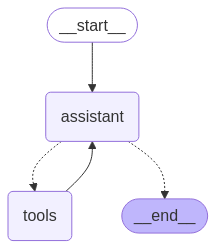

In [3]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [8]:
# Specify a thread
config = {"configurable": {"thread_id": "5"}}

# Specify an input
# messages = [HumanMessage(content="Придерживайся строгой формы ответы, это важно! один SQL запрос и один комментарий, если непонятно переспроси")]
messages = [HumanMessage(content="Покажи отгрузки за сегодня")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Покажи отгрузки за сегодня
================================== Ai Message ==================================

SELECT VBRK_VBELN AS Invoice_Code,
       VBRP_POSNR AS Position_Number,
       VBRK_FKDAT AS Shipment_Date,
       VBRK_ZZPERNR_ZM AS Manager_Code,
       VBRP_MATNR AS Material_Code,
       VBRP_FKIMG AS Quantity_Sold,
       ZAREVENF_RUB AS Revenue_RUB
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT = '20250326'


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
# messages = [HumanMessage(content="Сколько клиентов отгрузилось на дальнем востоке в прошлом году")]
for query in user_querys[2:]:
    messages = [HumanMessage(content=query)]

    # Run
    messages = react_graph_memory.invoke({"messages": messages},config)
    for m in messages['messages']:
        m.pretty_print()
    print("#"*100)

================================ Human Message =================================

Покажи отгрузки за сегодня
================================== Ai Message ==================================

```sql
SELECT VBRK_VBELN AS КодФактуры,
       VBRP_POSNR AS ПозицияФактуры,
       VBRK_FKDAT AS ДатаФактуры,
       VBRK_ZZPERNR_ZM AS МенеджерСделки,
       VBRP_MATNR AS Материал,
       VBRP_FKIMG AS Количество,
       ZAREVENF_RUB AS ВыручкаРубли
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT = '20250326'
```
===
Сегодня были следующие отгрузки:
<КодФактуры>, <ПозицияФактуры>, <ДатаФактуры>, <МенеджерСделки>, <Материал>, <Количество>, <ВыручкаРубли>.
================================ Human Message =================================

Сколько в прошлом месяце отгрузили на Урале
================================== Ai Message ==================================

```sql
SELECT SUM(VBRP_FKIMG) AS ОбщееКоличествоОтгруженного
FROM SAPABAP1.ZZSDM_117_CUS
WHERE VBRK_FKDAT >= '20250201' -- Начало прошлого мес